<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/MaskFormer/Fine-tuning/Fine_tuning_MaskFormerForInstanceSegmentation_on_semantic_sidewalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune MaskFormer for semantic segmentation

In this notebook, we'll show how to fine-tune the model on a semantic segmentation dataset. In semantic segmentation, the goal for the model is to segment photovoltaiv panels so each images has a label which is a mask indicates all the presented photovoltaic panels

Make sure to run this notebook on a GPU.

## Set-up environment

First, we install the necessary libraries. 🤗, what else? Oh yes we'll also use [Albumentations](https://albumentations.ai/), for some data augmentation to make the model more robust. You can of course use any data augmentation library of your choice.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [2]:
!pip install -q datasets

In [3]:
!pip install -q albumentations

## Load data

Now let's the dataset from the hub.


In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_key = user_secrets.get_secret("HF_key")

In [5]:
from huggingface_hub import login

In [6]:
from huggingface_hub import login
login(HF_key)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [7]:
from datasets import load_dataset

dataset = load_dataset("mouadenna/satellite_PV_dataset")


Generating train split:   0%|          | 0/4583 [00:00<?, ? examples/s]

our dataset consists of 4583 sample

In [8]:
dataset #4583

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 4583
    })
})

In [9]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

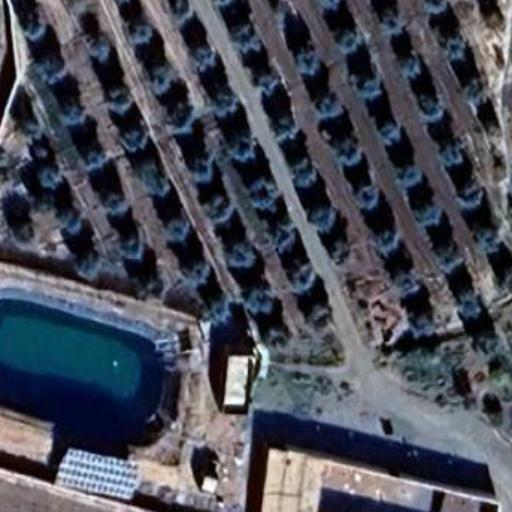

In [10]:
# let's look at one example
example = train_ds[1]
image = example['pixel_values']
image

In [11]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(train_ds[1]['label'])
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
np.unique(segmentation_map)

array([0, 1], dtype=uint8)

Cool, but we want to know the actual class names. For that we need the id2label mapping, which is hosted in a repo on the hub.

In [13]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"mouadenna/satellite_PV_dataset"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

id2label.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

{0: 'unlabeled', 1: 'PV'}


In [14]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['unlabeled', 'PV']


Let's visualize it:

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the color palette
def color_palette():
    """Color palette for two classes."""
    return [[0, 0, 0], [0, 0, 255]]  # Black for 'unlabeled' (not used) and blue for 'PV'

palette = color_palette()


# Create the color segmentation map
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)  # height, width, 3


In [16]:
np.unique(color_segmentation_map),color_segmentation_map.shape

(array([0], dtype=uint8), (512, 512, 3))

0
1


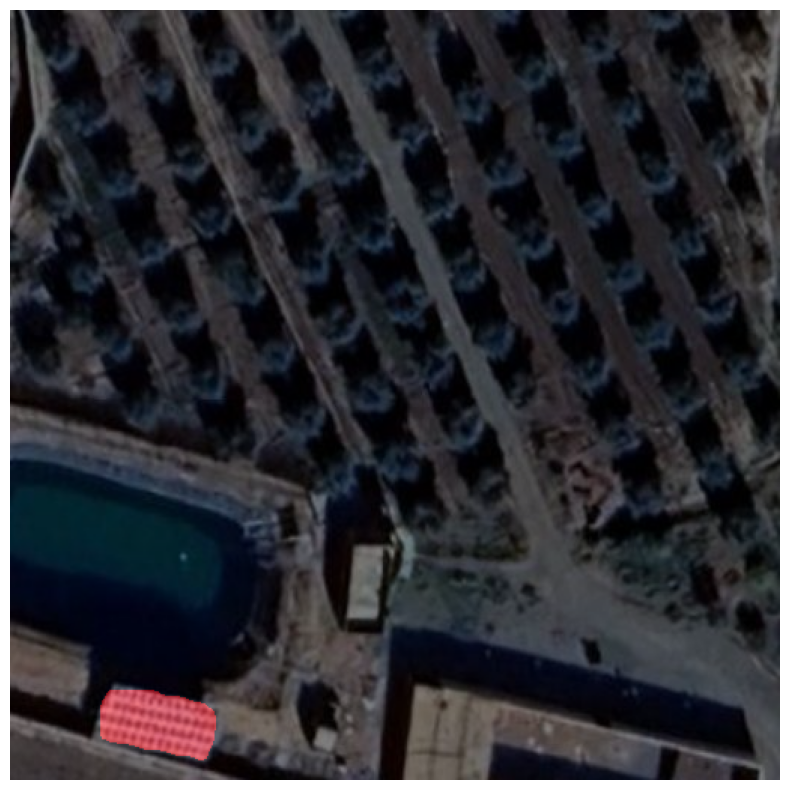

In [17]:
for label, color in enumerate(palette):
    print(label)
    if label == 1:  # Only apply color for 'PV' label
        color_segmentation_map[segmentation_map == label, :] = color

# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

# Overlay the segmentation map on the image
img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

# Display the result
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


## Create PyTorch Dataset

Next, we create a standard PyTorch dataset. Each item of the dataset consists of the image and corresponding ground truth segmentation map. We also include the original image + map (before preprocessing) in order to compute metrics like mIoU.

In [18]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['pixel_values'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])
        
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

The dataset accepts image transformations which can be applied on both the image and the map. Here we use Albumentations, to resize, randomly crop + flip and normalize them. Data augmentation is a widely used technique in computer vision to make the model more robust.

In [19]:

#from tqdm import tqdm
#image_arrays = np.stack([np.array(img) for img in tqdm(train_ds["pixel_values"])])

# Calculate mean and std along the (0, 1, 2) axes (height, width, channels)
#mean = np.mean(image_arrays, axis=(0, 1, 2))
#std = np.std(image_arrays, axis=(0, 1, 2))

#print("Mean:", mean)
#print("Standard Deviation:", std)





In [20]:
import albumentations as A

MEAN = np.array([114.84201968, 109.95146836 ,110.99874014])/255
STD = np.array([61.19193, 51.41192296, 47.74875693])/255

train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=359, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=360, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1),
                               contrast_limit=(-0.1,0.1),
                               p=0.5),
    A.Normalize(mean=MEAN, std=STD)
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=MEAN, std=STD),

])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

### visualise a sample

In [21]:
image, segmentation_map, _, _ = train_dataset[101]
print(image.shape)
print(segmentation_map.shape)

(3, 512, 512)
(512, 512)


In [22]:
image

array([[[0.44381636, 0.44381636, 0.42747435, ..., 0.4601584 ,
         0.4601584 , 0.4601584 ],
        [0.44381636, 0.42747435, 0.42747435, ..., 0.4601584 ,
         0.4601584 , 0.4601584 ],
        [0.42747435, 0.42747435, 0.42747435, ..., 0.4601584 ,
         0.4601584 , 0.4601584 ],
        ...,
        [0.8033409 , 0.8196829 , 0.83602494, ..., 0.98310316,
         1.0157872 , 1.0484712 ],
        [0.8196829 , 0.83602494, 0.83602494, ..., 0.98310316,
         1.0157872 , 1.0648133 ],
        [0.83602494, 0.852367  , 0.83602494, ..., 1.0157872 ,
         1.0484712 , 1.0811553 ]],

       [[0.5455647 , 0.5455647 , 0.526114  , ..., 0.42886025,
         0.42886025, 0.42886025],
        [0.5455647 , 0.526114  , 0.526114  , ..., 0.42886025,
         0.42886025, 0.42886025],
        [0.526114  , 0.526114  , 0.526114  , ..., 0.42886025,
         0.42886025, 0.42886025],
        ...,
        [0.72062135, 0.74007213, 0.75952286, ..., 0.9540303 ,
         0.973481  , 1.0123825 ],
        [0.7

A great way to check that our data augmentations are working well is by denormalizing the pixel values. So here we perform the inverse operation of Albumentations' normalize method and visualize the image:

In [23]:

def unnormalize(image, mean=MEAN, std=STD):
    unnormalized_image = image * std + mean
    unnormalized_image = np.clip(unnormalized_image * 255, 0, 255).astype(np.uint8)
    return unnormalized_image

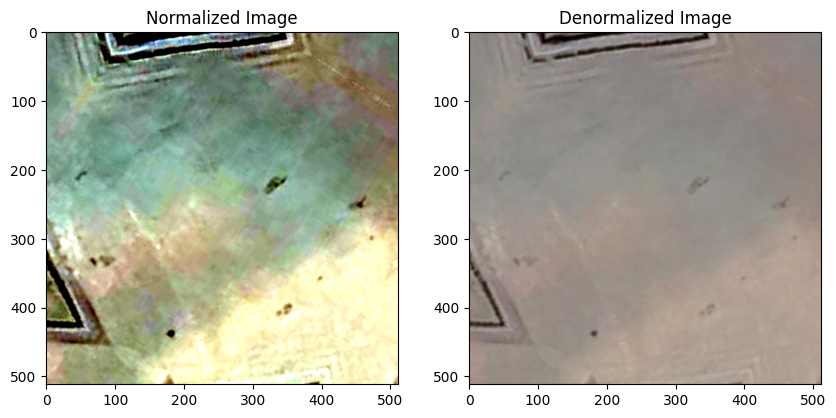

In [24]:

normalized_image, _, _, _ = train_dataset[101]
normalized_image = normalized_image.transpose(1, 2, 0)  # Convert back to H, W, C format

# Denormalize image
unnormalized_image = unnormalize(normalized_image, MEAN, STD)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot normalized image
axes[0].imshow(normalized_image)
axes[0].set_title('Normalized Image')

# Plot denormalized image
axes[1].imshow(unnormalized_image)
axes[1].set_title('Denormalized Image')

plt.show()

This looks ok. Let's also verify whether the corresponding ground truth map is still ok.

In [25]:
segmentation_map.shape

(512, 512)

In [26]:
labels

['unlabeled', 'PV']

In [27]:
#labels = [id2label[label] for label in np.unique(segmentation_map)]
#print(labels)

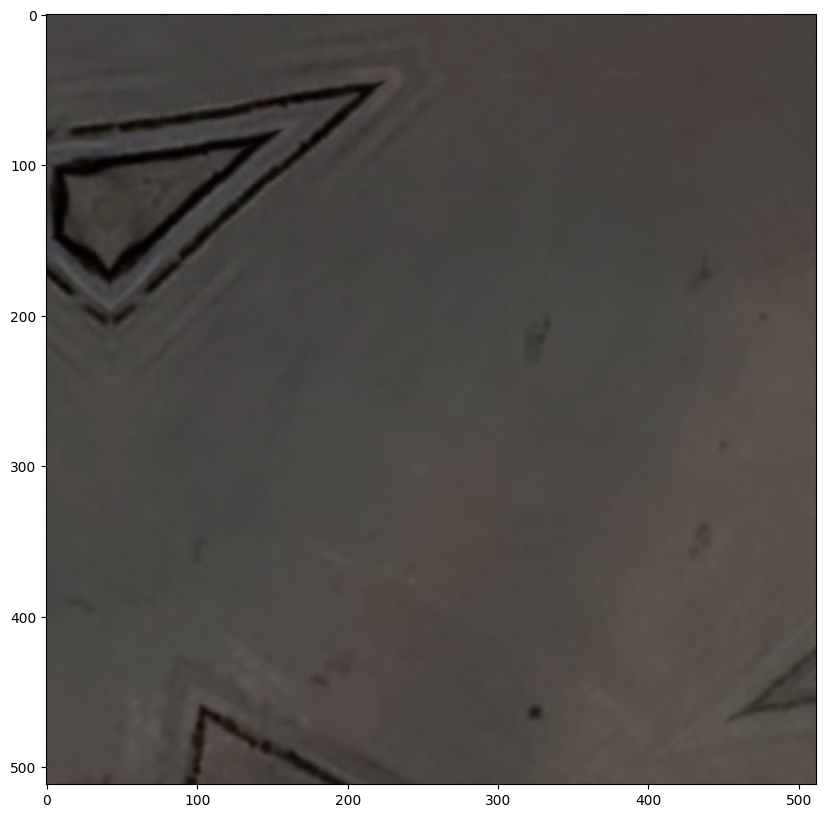

In [28]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = unnormalize(np.moveaxis(image, 0, -1)) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Ok great!

## Create PyTorch DataLoaders

Next we create PyTorch DataLoaders, which allow us to get batches of the dataset. For that we define a custom so-called "collate function", which PyTorch allows you to do. It's in this function that we'll use the preprocessor of MaskFormer, to turn the images + maps into the format that MaskFormer expects.

It's here that we make the paradigm shift that the MaskFormer authors introduced: the "per-pixel" annotations of the segmentation map will be turned into a set of binary masks and corresponding labels. It's this format on which we can train MaskFormer. MaskFormer namely casts any image segmentation task to this format.

In [29]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=255, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-07-10 18:53:24.308988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 18:53:24.309121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 18:53:24.452052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [30]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    
    return batch

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

## Verify data (!!)

Next, it's ALWAYS very important to check whether the data you feed to the model actually makes sense. It's one of the main principles of [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/), if you wanna debug your neural networks.

Let's check the first batch, and its content.

In [31]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k,v.shape)
    else:
        print(k,v[0].shape)

pixel_values torch.Size([4, 3, 512, 512])
pixel_mask torch.Size([4, 512, 512])
mask_labels torch.Size([1, 512, 512])
class_labels torch.Size([1])
original_images (512, 512, 3)
original_segmentation_maps (512, 512)


In [32]:
#batch["class_labels"]=[batch["class_labels"][0]/255]

In [33]:
#batch["class_labels"]=[batch["class_labels"][0].long()]

In [34]:
batch["class_labels"]

[tensor([0]), tensor([0]), tensor([0]), tensor([0, 1])]

In [35]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 512, 512)

Again, let's denormalize an image and see what we got.

In [36]:
pixel_values

array([[[-1.4845424e+00, -1.4355164e+00, -1.3864902e+00, ...,
         -1.6479626e+00, -1.5989366e+00, -1.6643046e+00],
        [-9.2891359e-01, -8.6354548e-01, -8.1451941e-01, ...,
         -1.7950408e+00, -1.7460147e+00, -1.7950408e+00],
        [-7.3280931e-01, -6.3475716e-01, -4.0596884e-01, ...,
         -1.8767509e+00, -1.8767509e+00, -1.8767509e+00],
        ...,
        [-1.7623568e+00, -1.7623568e+00, -1.7786988e+00, ...,
         -1.6806467e+00, -1.6479626e+00, -1.5989366e+00],
        [-1.7623568e+00, -1.7623568e+00, -1.7623568e+00, ...,
         -1.6316206e+00, -1.6152786e+00, -1.5662525e+00],
        [-1.7460147e+00, -1.7623568e+00, -1.7623568e+00, ...,
         -1.6152786e+00, -1.5825945e+00, -1.5825945e+00]],

       [[-1.2828050e+00, -1.2244527e+00, -1.1661005e+00, ...,
         -1.5162138e+00, -1.4578617e+00, -1.5356646e+00],
        [-6.2147975e-01, -5.4367679e-01, -4.8532456e-01, ...,
         -1.6912705e+00, -1.6329182e+00, -1.6912705e+00],
        [-3.8807085e-01, 

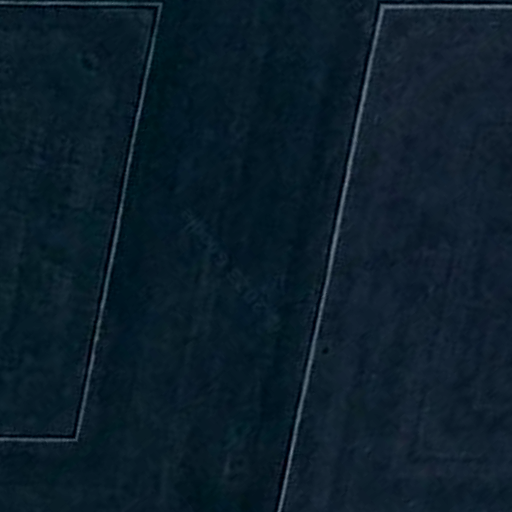

In [37]:
from PIL import Image
unnormalized_image = (pixel_values * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image*255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Let's verify the corresponding binary masks + class labels.

In [38]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['unlabeled']


In [39]:
def visualize_mask(labels, label_name):
    print("Label:", label_name)
    idx = labels.index(label_name)

    visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
    return Image.fromarray(visual_mask)

In [40]:
batch["mask_labels"][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [41]:
labels

['unlabeled']

In [42]:
#visualize_mask(labels, "PV")

## Define model

Next, we define the model. We equip the model with pretrained weights from the 🤗 hub. We will replace only the classification head. For that we provide the id2label mapping, and specify to ignore mismatches keys to replace the already fine-tuned classification head.

In [43]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down

See also the warning here: it's telling us that we are only replacing the class_predictor, which makes sense. As it's the only parameters that we will train from scratch.

## Compute initial loss

Another good way to debug neural networks is to verify the initial loss, see if it makes sense.

In [44]:
#batch["pixel_values"] = batch["pixel_values"].float()

In [45]:
#batch["class_labels"] = batch["class_labels"].float()

In [46]:
batch["pixel_values"].shape

torch.Size([4, 3, 512, 512])

In [47]:
batch["class_labels"]

[tensor([0]), tensor([0]), tensor([0]), tensor([0, 1])]

In [48]:
batch["mask_labels"][0].shape

torch.Size([1, 512, 512])

In [49]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [50]:

outputs.loss

tensor(1.3164, grad_fn=<AddBackward0>)

## Train the model

It's time to train the model! We'll use the mIoU metric to track progress.

In [51]:
!pip install -q evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [52]:
import evaluate

metric = evaluate.load("mean_iou")

## Config

In [53]:
LR=5e-5
EPOCHS=1

In [54]:
import torch
from tqdm.auto import tqdm
import evaluate
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [55]:


# Initialize the metric object for IoU calculation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

for epoch in range(EPOCHS):
    print("Epoch:", epoch)
    model.train()
    running_loss = 0.0
    num_samples = 0

    for idx, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        batch_size = batch["pixel_values"].size(0)
        running_loss += loss.item() * batch_size
        num_samples += batch_size

        if idx % 100 == 0:
            print(f"Train Step {idx} - Loss: {running_loss / num_samples:.4f}")

    # Validation phase
    model.eval()
    
    # Reinitialize the metric for this validation phase
    metric = evaluate.load("mean_iou")

    for idx, batch in enumerate(tqdm(test_dataloader)):
        pixel_values = batch["pixel_values"]
        
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values.to(device))

        original_images = batch["original_images"]
        target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
        predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

        ground_truth_segmentation_maps = batch["original_segmentation_maps"]
        metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
    
    # Compute and log validation metrics
    metrics = metric.compute(num_labels=len(id2label), ignore_index=0)
    print(f"Epoch {epoch} - Mean IoU: {metrics['mean_iou']:.4f}")

    # Adjust learning rate based on validation metric
    scheduler.step(metrics['mean_iou'])


Epoch: 0


  0%|          | 0/917 [00:00<?, ?it/s]

Train Step 0 - Loss: 1.5595
Train Step 100 - Loss: 0.2956
Train Step 200 - Loss: 0.2096
Train Step 300 - Loss: 0.1721
Train Step 400 - Loss: 0.1556
Train Step 500 - Loss: 0.1457
Train Step 600 - Loss: 0.1404
Train Step 700 - Loss: 0.1338
Train Step 800 - Loss: 0.1290
Train Step 900 - Loss: 0.1232


  0%|          | 0/230 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Epoch 0 - Mean IoU: 0.4464


In [56]:
#16min 6s for one epoch

## Saving the model

In [57]:
preprocessor.do_normalize = True
preprocessor.do_resize = True
preprocessor.do_rescale = True
# Push your model and preprocessor to the Hub
model.push_to_hub("maskformer-swin-base-ade-PV-segmentation")
preprocessor.push_to_hub("maskformer-swin-base-ade-PV-segmentation")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/411M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mouadenna/maskformer-swin-base-ade-PV-segmentation/commit/54ed7c8da54a82b8c4ae9404feb5c503d38b9f60', commit_message='Upload processor', commit_description='', oid='54ed7c8da54a82b8c4ae9404feb5c503d38b9f60', pr_url=None, pr_revision=None, pr_num=None)

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of a test batch.

In [58]:
# let's take the first test batch
#batch = next(iter(test_dataloader))
#for k,v in batch.items():
#    if isinstance(v, torch.Tensor):
#        print(k,v.shape)
#    else:
#        print(k,len(v))

In [59]:
## forward pass
#with torch.no_grad():
#  outputs = model(batch["pixel_values"].to(device))

In [60]:
#original_images = batch["original_images"]
#target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
#predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

In [61]:
#torch.unique(predicted_segmentation_maps[0])

In [62]:
#image = batch["original_images"][0]
#Image.fromarray(image)

In [63]:
#import numpy as np
#import matplotlib.pyplot as plt

#segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

#color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
#for label, color in enumerate(palette):
#    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
#ground_truth_color_seg = color_segmentation_map[..., ::-1]

#img = image * 0.5 + ground_truth_color_seg * 0.5
#img = img.astype(np.uint8)

#plt.figure(figsize=(15, 10))
#plt.imshow(img)
#plt.show()

Compare to the ground truth:

In [64]:
#import numpy as np
#import matplotlib.pyplot as plt

#segmentation_map = batch["original_segmentation_maps"][0]

#color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
#for label, color in enumerate(palette):
#    color_segmentation_map[segmentation_map == label, :] = color
## Convert to BGR
#ground_truth_color_seg = color_segmentation_map[..., ::-1]

#img = image * 0.5 + ground_truth_color_seg * 0.5
#img = img.astype(np.uint8)

#plt.figure(figsize=(15, 10))
#plt.imshow(img)
#plt.show()

I didn't do a lot of training (only 2 epochs), and results don't look too bad. I'd suggest checking the paper to find all details regarding training hyperparameters (number of epochs, learning rate, etc.).